# Homework 1: Bayes optimal classifier
Students: P Anand, H Chaturvedi

## Problem 1: Linear Classifier 

### Generating 10 centroids for inputs ($x$'s), that will be used to generate a Gaussian Mixture Model.

<IPython.core.display.Javascript object>


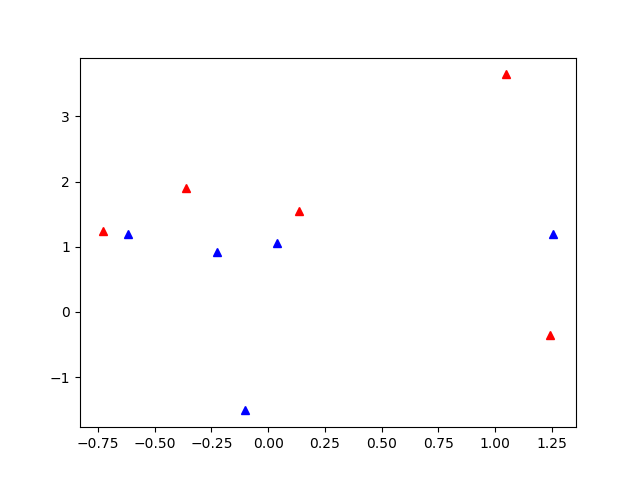

In [158]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np, pickle
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

# Generating 10 centroids for inputs (x's)
x_centroids_class1 = np.random.multivariate_normal(mean = [1, 0], cov = np.identity(2), 
                                                   size = 5) #Class 1 centroids
x_centroids_class2 = np.random.multivariate_normal(mean = [0, 1], cov = np.identity(2), 
                                                   size = 5) #Class 2 centroids
x_centroids = np.append(x_centroids_class1, x_centroids_class2, axis = 0) #All centroids

#plotting
ax = plt.subplots()[1]
ax.plot(x_centroids_class1[:, 0], x_centroids_class1[:, 1], marker = '^', linestyle = '', color = 'blue')
ax.plot(x_centroids_class2[:, 0], x_centroids_class2[:, 1], marker = '^', linestyle = '', color = 'red')

### Generating training data around centroids

<IPython.core.display.Javascript object>


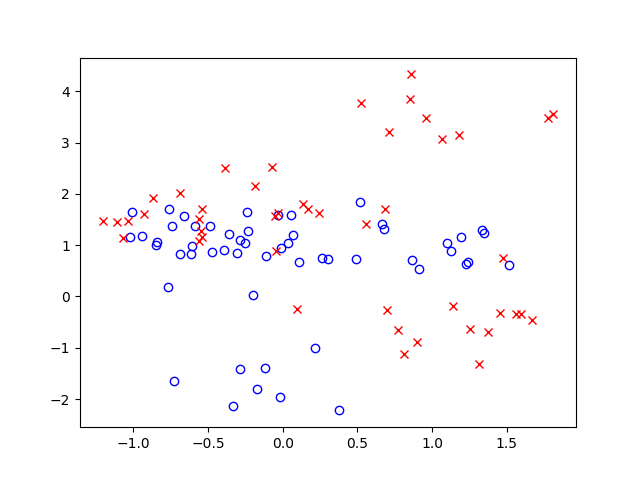

In [159]:
# Generating data around centroids
x_train, y_train, x_train_subclass = [], [], []

for _ in range(100):
    centroid_idx = np.random.choice(10) #sample i for m_i from 1 to 10
    x_train_subclass.append(centroid_idx)
    x_train.append(np.random.multivariate_normal(mean = x_centroids[centroid_idx], 
                                                 cov = np.identity(2)/5.)) #sample xj
    if centroid_idx < 5: y_train.append(0) #if i in {0, ..4}, y = 0
    else: y_train.append(1) #if i in {5, ..9}, y = 1

x_train, y_train, x_train_subclass = np.array(x_train), np.array(y_train), np.array(x_train_subclass) #lists to arrays
#plotting 
ax = plt.subplots()[1]
ax.plot(x_train[y_train == 0, 0], x_train[y_train == 0, 1], linestyle = '', marker = 'o', color = 'blue', 
        markerfacecolor = 'none')
ax.plot(x_train[y_train == 1, 0], x_train[y_train == 1, 1], linestyle = '', marker = 'x', color = 'red')



### Functions for plotting boundary and getting FP and FN rates

In [160]:
def plot_boundary(ax, clf, x, y, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    params: dictionary of params to pass to contourf, optional
    """
    
    def make_meshgrid(x, y):
        grid_res = 500
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)*1./grid_res)[:grid_res],
                             np.arange(y_min, y_max, (y_max - y_min)*1./grid_res)[:grid_res])
        return xx, yy
        
    xx, yy = make_meshgrid(x, y)
    Z = clf(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, **params)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
def false_rates(clf, x, y):
    tn, fp, fn, tp = confusion_matrix(y, clf(x)).ravel()
    fp_rate, fn_rate = (fp + 0.)/(fp + tn)*100., (fn + 0.)/(fn + tp)*100.
    return fp_rate, fn_rate

### Testing a linear model

We fit a linear model to the training data and draw the decision boundary (subspace of $x$ where $y \approx 0.5$). We highlight the false positive and false negatives in the model predictions and print the rates of both. The model performs quite poorly.

<IPython.core.display.Javascript object>


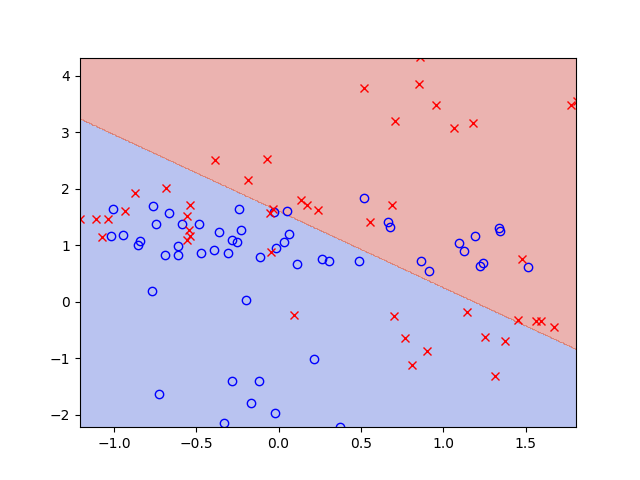

false positive rate = 25.9259259259% , false negative rate = 52.1739130435%


In [161]:
#train regression model
model = linear_model.LinearRegression()
model.fit(X = x_train, y = y_train)
lin_clf = lambda x: np.floor(model.predict(X = x) + 0.5)

#plotting boundary
ax_lin = pickle.loads(pickle.dumps(ax))
plot_boundary(ax_lin, lin_clf, x_train[:, 0], 
              x_train[:, 1], cmap = plt.cm.coolwarm, alpha = 0.4)

#fp and fn rates
fp_rate, fn_rate = false_rates(lin_clf, x_train, y_train)
print 'false positive rate = ' + str(fp_rate) + '% , false negative rate = ' + str(fn_rate) + '%'

## Problem 2: Bayes Optimal Classifier (BOC) derivation
Deriving optimal separating boundary, given all parameters of the data generating model

## Problem 4: BOC implementation, given only subclass labels

<IPython.core.display.Javascript object>


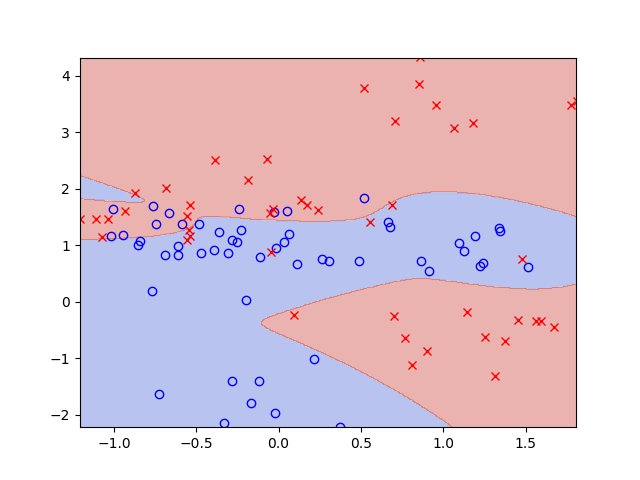

false positive rate = 20.3703703704% , false negative rate = 15.2173913043%


In [162]:
#bayes classifier
from scipy.stats import multivariate_normal as mvn
def bayes_clf(X, subc_means, subc_covs):
    prob_class2_numer = np.sum([mvn.pdf(x = X, mean = mean, cov = cov) for mean, cov 
                           in zip(subc_means[5:], subc_covs[5:])], axis = 0)
    prob_class2_denom = np.sum([mvn.pdf(x = X, mean = mean, cov = cov) for mean, cov 
                           in zip(subc_means, subc_covs)], axis = 0)
    prob_class2 = np.divide(prob_class2_numer, prob_class2_denom)
    return np.floor(prob_class2 + 0.5)

#compute subclass means and covs, given only subclass labels
subc_means, subc_covs = [], []
for subc in range(10):
    x_subc = x_train[x_train_subclass == subc]
    subc_means.append(np.mean(x_subc, axis = 0))
    subc_covs.append(np.cov(x_subc, rowvar = False))
subc_means, subc_covs = np.array(subc_means), np.array(subc_covs)

#bayes_clf for computed means, covs
bayes_clf_2 = lambda x: bayes_clf(X = x, subc_means = subc_means, subc_covs = subc_covs)
    
#plotting boundary
ax_bay = pickle.loads(pickle.dumps(ax))
plot_boundary(ax_bay, bayes_clf_2, x_train[:, 0], 
              x_train[:, 1], cmap = plt.cm.coolwarm, alpha = 0.4)

#fp and fn rates
fp_rate, fn_rate = false_rates(bayes_clf_2, x_train, y_train)
print 'false positive rate = ' + str(fp_rate) + '% , false negative rate = ' + str(fn_rate) + '%'
